# Introduction

The notebook is intended to perform a binary classification over the 'Response' label.

In [34]:
# Import Standard Modules
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.linear_model import LogisticRegression

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import xgboost as xgb

import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier

import plotly.graph_objects as go
import plotly.express as ex

# Set Pandas Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Read Data

In [2]:
# Read data
data = pd.read_csv('./../data/marketing_campaign_prepared.csv', encoding='latin1', sep=';')

# Data Pre-processing

## Features & Label Definition

The 'ID' column does not bring any useful information.

In [3]:
# Define x and y
X = data.drop(['ID', 'Response'], axis=1)
y = data['Response']

## Train & Test Split

Since the label is characterized by a strong imbalancing in the class distribution, we need to address it carefully:
1. Ensure that the training and test sets have the same proportions of the two classes
2. Oversample the minor class (i.e., randomly duplicate examples)
3. Undersample the major class (i.e., randomly delete examples)
4. Use several metrics (e.g., Accuracy, Precision, Recall, AUC)

Use StratifiedShuffleSplit. This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.

Note: like the ShuffleSplit strategy, stratified random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [4]:
# Standard train & test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Define the a Stratified K-fold Shuffle Splitter
stratified_kfold = StratifiedShuffleSplit(n_splits=10,
                                          test_size=.3, 
                                          random_state=0)

## Feature Selection

In [6]:
# Numerical Features
numerical_features = ['Year_Birth', 
                      'Income', 
                      'Recency', 
                      'MntWines', 
                      'MntFruits', 
                      'MntMeatProducts', 
                      'MntFishProducts', 
                      'MntSweetProducts', 
                      'MntGoldProds', 
                      'NumDealsPurchases', 
                      'NumWebPurchases', 
                      'NumCatalogPurchases', 
                      'NumStorePurchases', 
                      'NumWebVisitsMonth']

# Categorical Text Features
categorical_text_features = ['Education', 
                             'Marital_Status']

# Categorical Numerical Features
categorical_numerical_features = ['Kidhome', 
                                  'Teenhome', 
                                  'AcceptedCmp1', 
                                  'AcceptedCmp2', 
                                  'AcceptedCmp3', 
                                  'AcceptedCmp4', 
                                  'AcceptedCmp5', 
                                  'Complain', 
                                  'Dt_Customer_month', 
                                  'Dt_Customer_dayofweek']

## Data Standardization

Transform the individual features to look more or less like standard normally distributed data: Gaussian with zero mean and unit variance.

Keep in mind that tree-based methods are scale-invariant, so data standardization is not required.

Standardization has to go after training-test split. That's because, standardizing the whole dataset and then split, would introduce into the training set some information about the mean and std of the test set. Remember to standardize the test set with the same scaler trained on the training set. This would be addressed by constructing a pipeline with the scaler as a step.

In [7]:
# Define the ColumnTransformer
column_transformer = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features),
    ('categorical_text', OneHotEncoder(), categorical_text_features),
    ('categorical_numerical', 'passthrough', categorical_numerical_features)
], verbose_feature_names_out=True)

In [8]:
# Fit the ColumnTransformer
_ = column_transformer.fit(X_train)

In [9]:
# Transform the columns
X_train_transformed = pd.DataFrame(column_transformer.transform(X_train), columns=column_transformer.get_feature_names_out())
X_test_transformed = pd.DataFrame(column_transformer.transform(X_test), columns=column_transformer.get_feature_names_out())

# Models Definition

In [10]:
# Define the used metrics
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_score']

In [11]:
# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

## Logistic Regression

First benchmark model. Use standard train & test split and fit the logistic regression.

In [12]:
# Define the model
model_lr = LogisticRegression(max_iter=500)

# Train the model
model_lr.fit(X_train_transformed, y_train)

# Predictions
predictions_lr = model_lr.predict(X_test_transformed)

In [13]:
# Model evaluation
accuracy_lr = round(accuracy_score(y_test, predictions_lr) * 100, 2)
precision_lr = round(precision_score(y_test, predictions_lr) * 100, 2)
recall_lr = round(recall_score(y_test, predictions_lr) * 100, 2)
f1_lr = round(f1_score(y_test, predictions_lr) * 100, 2)
roc_auc_lr = round(roc_auc_score(y_test, predictions_lr) * 100, 2)

print('Model accuracy: {}%'.format(accuracy_lr))
print('Model precision: {}%'.format(precision_lr))
print('Model recall: {}%'.format(recall_lr))
print('Model f1 score: {}%'.format(f1_lr))
print('Model ROC AUC: {}%'.format(roc_auc_lr))

Model accuracy: 90.12%
Model precision: 53.85%
Model recall: 26.92%
Model f1 score: 35.9%
Model ROC AUC: 62.14%


## Logistic Regression - Pipeline

Use the same model as before, but within a pipeline (experimental purposes only).

In [14]:
# Define the model
model_lr_pipe = LogisticRegression(max_iter=500)

# Define the pipeline
lr_pipe = Pipeline([
    ('feature_transformation', column_transformer),
    ('logistic_regression', model_lr_pipe)
])

# Train the pipeline
lr_pipe.fit(X_train, y_train)

# Predictions
predictions_lr_pipe = lr_pipe.predict(X_test)

In [15]:
# Model evaluation
accuracy_lr_pipe = round(accuracy_score(y_test, predictions_lr_pipe) * 100, 2)
precision_lr_pipe = round(precision_score(y_test, predictions_lr_pipe) * 100, 2)
recall_lr_pipe = round(recall_score(y_test, predictions_lr_pipe) * 100, 2)
f1_lr_pipe = round(f1_score(y_test, predictions_lr_pipe) * 100, 2)
roc_auc_lr_pipe = round(roc_auc_score(y_test, predictions_lr_pipe) * 100, 2)
cv_score_lr_pipe = round(cross_val_score(lr_pipe, X, y, cv=stratified_kfold).mean() * 100, 2)

print('Model accuracy: {}%'.format(accuracy_lr_pipe))
print('Model precision: {}%'.format(precision_lr_pipe))
print('Model recall: {}%'.format(recall_lr_pipe))
print('Model f1 score: {}%'.format(f1_lr_pipe))
print('Model ROC AUC: {}%'.format(roc_auc_lr_pipe))
print('Model Cross Validation score: {}%'.format(cv_score_lr_pipe))

Model accuracy: 90.12%
Model precision: 53.85%
Model recall: 26.92%
Model f1 score: 35.9%
Model ROC AUC: 62.14%
Model Cross Validation score: 91.37%


In [16]:
# Update 'performance' DataFrame
performance.loc['logistic_regression'] = [accuracy_lr_pipe, 
                                          precision_lr_pipe, 
                                          recall_lr_pipe, 
                                          f1_lr_pipe, 
                                          roc_auc_lr_pipe, 
                                          cv_score_lr_pipe]

## Logistic Regression - Cross-Validation

In [17]:
# Define the model
model_lr_cv = LogisticRegression(max_iter=500)

# Initialize metrics lists
accuracy_lr_cv_list = []
precision_lr_cv_list = []
recall_lr_cv_list = []
f1_lr_cv_list = []
roc_auc_lr_cv_list = []

# Train the model with K-fold
for train_index, test_index in stratified_kfold.split(X, y):
    
    # Define the pipeline
    pipeline_lr_cv = Pipeline([
        ('feature_transformation', column_transformer),
        ('logistic_regression', model_lr_cv)
    ])
        
    # Train the model
    pipeline_lr_cv.fit(X.iloc[train_index], y.iloc[train_index])

    # Get predicitons
    predictions_lr_cv = pipeline_lr_cv.predict(X.iloc[test_index])

    # Model evaluation
    accuracy_lr_cv_list.append(round(accuracy_score(y.iloc[test_index], predictions_lr_cv) * 100, 2))
    precision_lr_cv_list.append(round(precision_score(y.iloc[test_index], predictions_lr_cv) * 100, 2))
    recall_lr_cv_list.append(round(recall_score(y.iloc[test_index], predictions_lr_cv) * 100, 2))
    f1_lr_cv_list.append(round(f1_score(y.iloc[test_index], predictions_lr_cv) * 100, 2))
    roc_auc_lr_cv_list.append(round(roc_auc_score(y.iloc[test_index], predictions_lr_cv) * 100, 2))
    
# Compute average of metrics among the K-Folds
accuracy_lr_cv = round(np.mean(accuracy_lr_cv_list), 2)
precision_lr_cv = round(np.mean(precision_lr_cv_list), 2)
recall_lr_cv = round(np.mean(recall_lr_cv_list), 2)
f1_lr_cv = round(np.mean(f1_lr_cv_list), 2)
roc_auc_lr_cv = round(np.mean(roc_auc_lr_cv_list), 2)
cv_score_lr_cv = round(cross_val_score(pipeline_lr_cv, X, y, cv=stratified_kfold).mean() * 100, 2)

print('Model accuracy: {}%'.format(accuracy_lr_cv))
print('Model precision: {}%'.format(precision_lr_cv))
print('Model recall: {}%'.format(recall_lr_cv))
print('Model f1 score: {}%'.format(f1_lr_cv))
print('Model ROC AUC: {}%'.format(roc_auc_lr_cv))
print('Model Cross Validation score: {}%'.format(cv_score_lr_cv))

Model accuracy: 91.37%
Model precision: 68.69%
Model recall: 31.87%
Model f1 score: 43.34%
Model ROC AUC: 65.09%
Model Cross Validation score: 91.37%


In [18]:
# Update 'performance' DataFrame
performance.loc['logistic_regression_cv'] = [accuracy_lr_cv, 
                                             precision_lr_cv, 
                                             recall_lr_cv, 
                                             f1_lr_cv, 
                                             roc_auc_lr_cv, 
                                             cv_score_lr_cv]

## XGBoost

In [19]:
# Define the model
model_xbg_cv = xgb.XGBClassifier(objective='binary:logistic',
                                 eval_metric='auc',
                                 n_estimators=300,
                                 max_depth=8,
                                 min_child_weight=5,
                                 use_label_encoder=False)

# Initialize metrics lists
accuracy_xgb_cv_list = []
precision_xgb_cv_list = []
recall_xgb_cv_list = []
f1_xgb_cv_list = []
roc_auc_xgb_cv_list = []

# Train the model with K-fold
for train_index, test_index in stratified_kfold.split(X, y):
    
    # Define the pipeline
    pipeline_xgb_cv = Pipeline([
        ('feature_transformation', column_transformer),
        ('xgboost_classifier', model_xbg_cv)
    ])
        
    # Train the model
    pipeline_xgb_cv.fit(X.iloc[train_index], y.iloc[train_index])

    # Get predicitons
    predictions_xgb_cv = pipeline_xgb_cv.predict(X.iloc[test_index])

    # Model evaluation
    accuracy_xgb_cv_list.append(round(accuracy_score(y.iloc[test_index], predictions_xgb_cv) * 100, 2))
    precision_xgb_cv_list.append(round(precision_score(y.iloc[test_index], predictions_xgb_cv) * 100, 2))
    recall_xgb_cv_list.append(round(recall_score(y.iloc[test_index], predictions_xgb_cv) * 100, 2))
    f1_xgb_cv_list.append(round(f1_score(y.iloc[test_index], predictions_xgb_cv) * 100, 2))
    roc_auc_xgb_cv_list.append(round(roc_auc_score(y.iloc[test_index], predictions_xgb_cv) * 100, 2))
    
# Compute average of metrics among the K-Folds
accuracy_xgb_cv = round(np.mean(accuracy_xgb_cv_list), 2)
precision_xgb_cv = round(np.mean(precision_xgb_cv_list), 2)
recall_xgb_cv = round(np.mean(recall_xgb_cv_list), 2)
f1_xgb_cv = round(np.mean(f1_xgb_cv_list), 2)
roc_auc_xgb_cv = round(np.mean(roc_auc_xgb_cv_list), 2)
cv_score_xgb_cv = round(cross_val_score(pipeline_xgb_cv, X, y, cv=stratified_kfold).mean() * 100, 2)


print('Model accuracy: {}%'.format(accuracy_xgb_cv))
print('Model precision: {}%'.format(precision_xgb_cv))
print('Model recall: {}%'.format(recall_xgb_cv))
print('Model f1 score: {}%'.format(f1_xgb_cv))
print('Model ROC AUC: {}%'.format(roc_auc_xgb_cv))
print('Model Cross Validation score: {}%'.format(cv_score_xgb_cv))

Model accuracy: 90.54%
Model precision: 56.98%
Model recall: 38.75%
Model f1 score: 45.79%
Model ROC AUC: 67.66%
Model Cross Validation score: 90.54%


In [20]:
# Update 'performance' DataFrame
performance.loc['xgboost_classifier_cv'] = [accuracy_xgb_cv, 
                                            precision_xgb_cv, 
                                            recall_xgb_cv, 
                                            f1_xgb_cv, 
                                            roc_auc_xgb_cv, 
                                            cv_score_xgb_cv]

## XGBoost with HYPEROPT Bayesian Optimization

In [21]:
# Define the Hyperparamters space for Hyperopt
hyperopt_parameters_space = {
    'max_depth': hp.quniform("max_depth", 3, 40, 2),
    'gamma': hp.uniform ('gamma', 0, 1),
    #'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
    #'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
    #'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 60, 3),
    'n_estimators': hp.quniform('n_estimators', 100, 3000, 10)
}

In [22]:
# Define the Objective Function
def objective(space, column_transformer=column_transformer, cv=stratified_kfold, X=X, y=y):
    
    # Create the estimator
    clf=xgb.XGBClassifier(objective='binary:logistic',
                          eval_metric='auc',
                          n_estimators=int(space['n_estimators']), 
                          max_depth=int(space['max_depth']), 
                          gamma=space['gamma'],
                          #reg_alpha=int(space['reg_alpha']),
                          min_child_weight=int(space['min_child_weight']),
                          #colsample_bytree=int(space['colsample_bytree']),
                          use_label_encoder=False)
    
    # Define the Pipeline
    pipeline = Pipeline(steps=[
        ('feature_transformation', column_transformer), 
        ('classifier', clf)
    ]) 
   
    # Initialize losses lists
    log_loss_list = []
    
    # Train the model with K-fold
    for train_index, test_index in cv.split(X, y):
    
        # Train the model
        pipeline.fit(X.iloc[train_index], y.iloc[train_index])

        # Get predicitons
        predictions = pipeline.predict(X.iloc[test_index])
        
        # Model loss
        log_loss_list.append(round(log_loss(y.iloc[test_index], predictions) * 100, 2))
                                          
    # Compute average of metrics among the K-Folds
    log_loss_score = round(np.mean(log_loss_list), 2)
           
    return log_loss_score

In [23]:
# Perform the Hyperparameters Tuning
parameters_xgb_cv_hyperopt = fmin(fn=objective,
                                  space=hyperopt_parameters_space,
                                  algo=tpe.suggest,
                                  max_evals=5,
                                  trials=Trials())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:05<00:00, 13.00s/trial, best loss: 334.88]


In [24]:
# Create the model
model_xgb_cv_hyperopt = xgb.XGBClassifier(objective='binary:logistic',
                                          eval_metric='auc',
                                          n_estimators=int(parameters_xgb_cv_hyperopt['n_estimators']),
                                          max_depth=int(parameters_xgb_cv_hyperopt['max_depth']), 
                                          gamma=parameters_xgb_cv_hyperopt['gamma'],
                                          #reg_alpha=int(parameters_xgb_cv_hyperopt['reg_alpha']),
                                          min_child_weight=int(parameters_xgb_cv_hyperopt['min_child_weight']),
                                          #colsample_bytree=int(parameters_xgb_cv_hyperopt['colsample_bytree']),
                                          use_label_encoder=False)

# Initialize metrics lists
accuracy_xgb_cv_hyperopt_list = []
precision_xgb_cv_hyperopt_list = []
recall_xgb_cv_hyperopt_list = []
f1_xgb_cv_hyperopt_list = []
roc_auc_xgb_cv_hyperopt_list = []

# Train the model with K-fold
for train_index, test_index in stratified_kfold.split(X, y):
    
    # Define the pipeline
    pipeline_xgb_cv_hyperopt = Pipeline([
        ('feature_transformation', column_transformer),
        ('xgboost_classifier', model_xgb_cv_hyperopt)
    ])
        
    # Train the model
    pipeline_xgb_cv_hyperopt.fit(X.iloc[train_index], y.iloc[train_index])

    # Get predicitons
    predictions_xgb_cv_hyperopt = pipeline_xgb_cv_hyperopt.predict(X.iloc[test_index])

    # Model evaluation
    accuracy_xgb_cv_hyperopt_list.append(round(accuracy_score(y.iloc[test_index], predictions_xgb_cv_hyperopt) * 100, 2))
    precision_xgb_cv_hyperopt_list.append(round(precision_score(y.iloc[test_index], predictions_xgb_cv_hyperopt) * 100, 2))
    recall_xgb_cv_hyperopt_list.append(round(recall_score(y.iloc[test_index], predictions_xgb_cv_hyperopt) * 100, 2))
    f1_xgb_cv_hyperopt_list.append(round(f1_score(y.iloc[test_index], predictions_xgb_cv_hyperopt) * 100, 2))
    roc_auc_xgb_cv_hyperopt_list.append(round(roc_auc_score(y.iloc[test_index], predictions_xgb_cv_hyperopt) * 100, 2))
    
# Compute average of metrics among the K-Folds
accuracy_xgb_cv_hyperopt = round(np.mean(accuracy_xgb_cv_hyperopt_list), 2)
precision_xgb_cv_hyperopt = round(np.mean(precision_xgb_cv_hyperopt_list), 2)
recall_xgb_cv_hyperopt = round(np.mean(recall_xgb_cv_hyperopt_list), 2)
f1_xgb_cv_hyperopt = round(np.mean(f1_xgb_cv_hyperopt_list), 2)
roc_auc_xgb_cv_hyperopt = round(np.mean(roc_auc_xgb_cv_hyperopt_list), 2)
cv_score_xgb_cv_hyperopt = round(cross_val_score(pipeline_xgb_cv_hyperopt, X, y, cv=stratified_kfold).mean() * 100, 2)

print('Model accuracy: {}%'.format(accuracy_xgb_cv_hyperopt))
print('Model precision: {}%'.format(precision_xgb_cv_hyperopt))
print('Model recall: {}%'.format(recall_xgb_cv_hyperopt))
print('Model f1 score: {}%'.format(f1_xgb_cv_hyperopt))
print('Model ROC AUC: {}%'.format(roc_auc_xgb_cv_hyperopt))
print('Model Cross Validation score: {}%'.format(cv_score_xgb_cv_hyperopt))

Model accuracy: 90.3%
Model precision: 56.18%
Model recall: 33.96%
Model f1 score: 41.98%
Model ROC AUC: 65.41%
Model Cross Validation score: 90.3%


In [25]:
# Update 'performance' DataFrame
performance.loc['xgboost_classifier_cv_hyperopt'] = [accuracy_xgb_cv_hyperopt, 
                                                     precision_xgb_cv_hyperopt, 
                                                     recall_xgb_cv_hyperopt, 
                                                     f1_xgb_cv_hyperopt, 
                                                     roc_auc_xgb_cv_hyperopt, 
                                                     cv_score_xgb_cv_hyperopt]

## Dense Neural Network

A TensorFlow-based DNN with CUDA GPU training and Hyperparameters Optimization.
The objective is to compare XGBoost with Deep Learning.

<br>

**NOTE:** KerasClassifier is a wrapper to use Keras models with Scikit-Learn.

In [33]:
# Define the model structure and compile
def create_baseline():
    
    # Define model
    model_dnn_tf = tf.keras.models.Sequential([
        tf.keras.layers.Dense(26, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    
    # Compile model
    model_dnn_tf.compile(loss='binary_crossentropy', 
                         optimizer='adam', 
                         metrics=['accuracy'])
    
    return model_dnn_tf             

In [35]:
# Wrap the Keras model
# NOTE: Usci Scikeras to wrap the model
model_dnn_tf_wrapped = KerasClassifier(build_fn=create_baseline, 
                                       epochs=100, 
                                       batch_size=5, 
                                       verbose=0)

/var/folders/0t/njq6l7654w566vf2sbzchn3r0000gp/T/ipykernel_72872/449602008.py:2: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.



# Models Comparison

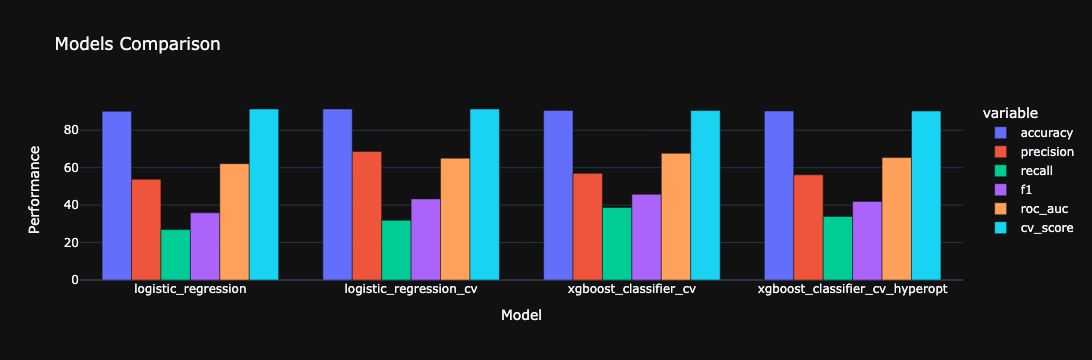

In [32]:
# Plot the models' performance
figure = ex.bar(performance,
                x=performance.index,
                y=performance.columns.values,
                labels={'index': 'Model', 'value': 'Performance'},
                barmode='group',
                title='Models Comparison',
                template='plotly_dark')

figure.show()